In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
import geopandas as gpd
import folium
from folium import Marker

In [3]:
df = pd.read_csv('./final_API.csv')
df.columns

Index(['RN', 'geometry', '대형마트_개수', '편의점_개수', '어린이집_개수', '학교_개수', '학원_개수',
       '주차장_개수', '주유소_개수', '지하철역_개수', '은행_개수', '문화시설_개수', '중개업소_개수', '공공기관_개수',
       '관광명소_개수', '숙박_개수', '음식점_개수', '카페_개수', '병원_개수', '약국_개수', '헬스클럽_개수',
       '셀프빨래방_개수', '집객시설_총_개수', '상주인구'],
      dtype='object')

## 수거함 입지 후보 지도 시각화


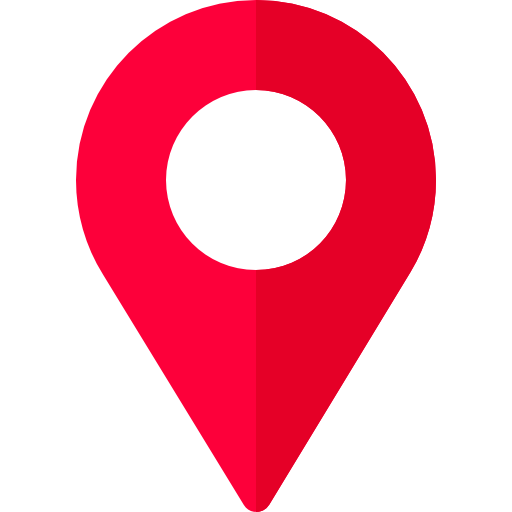
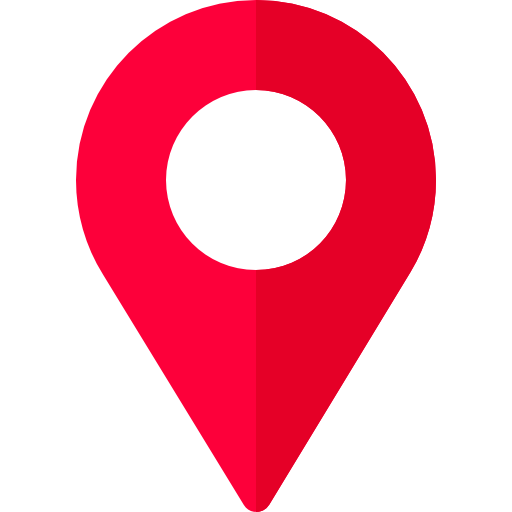
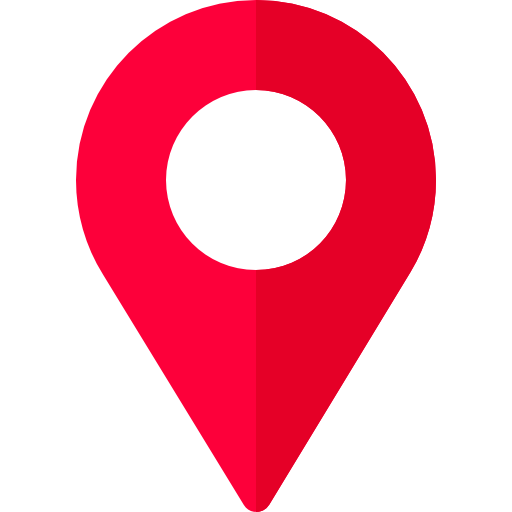
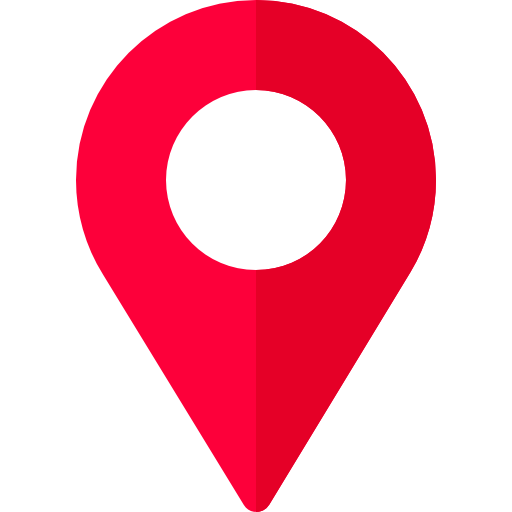
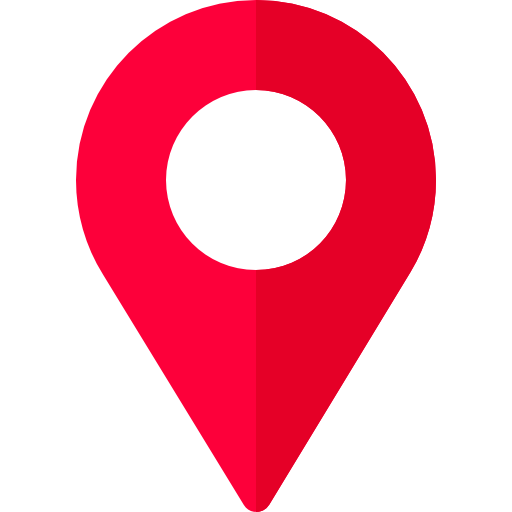
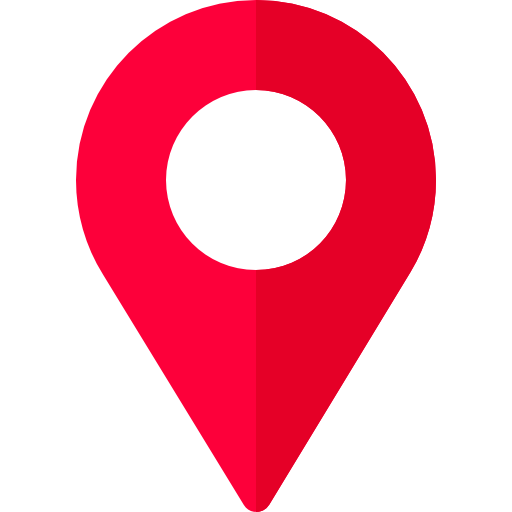
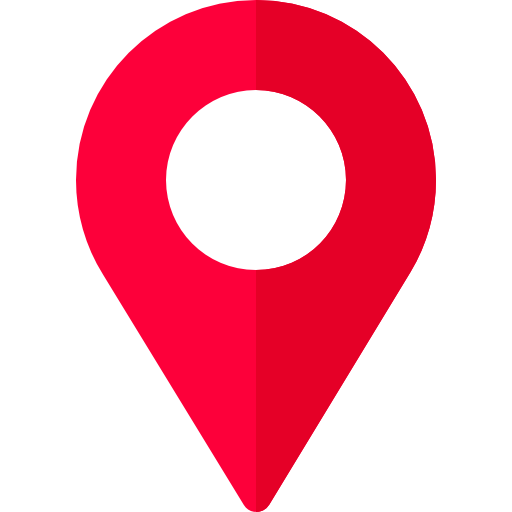
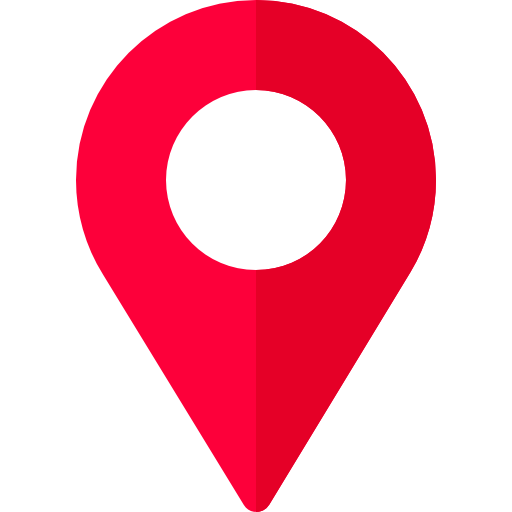
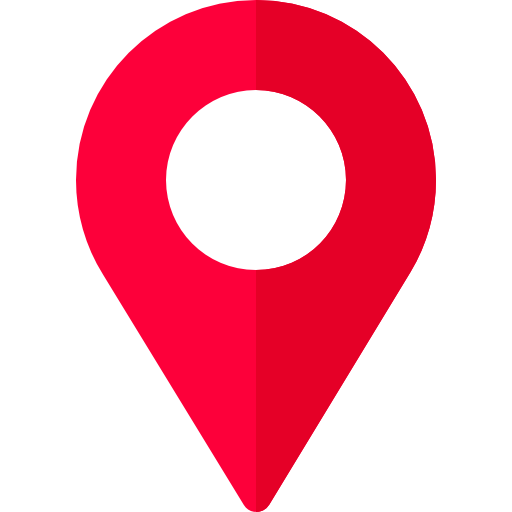
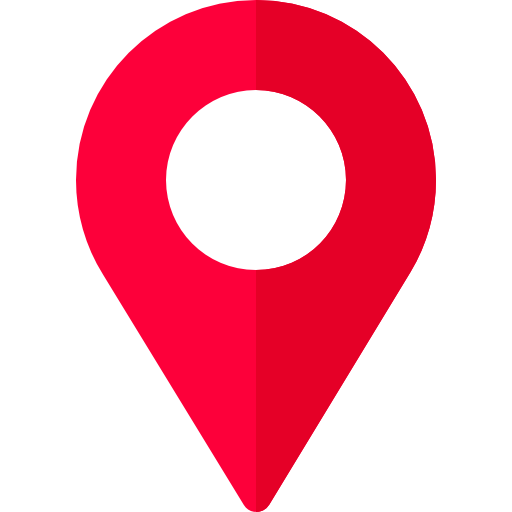
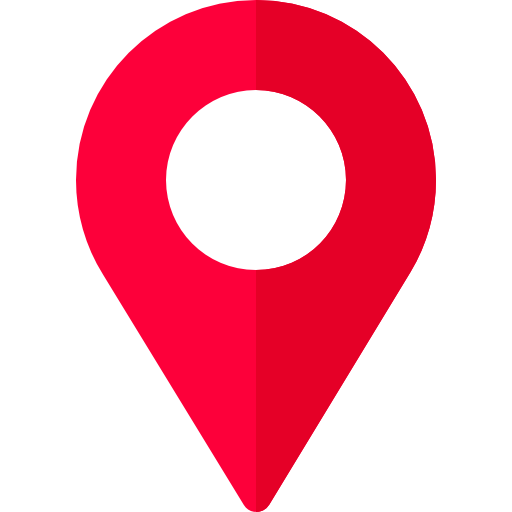
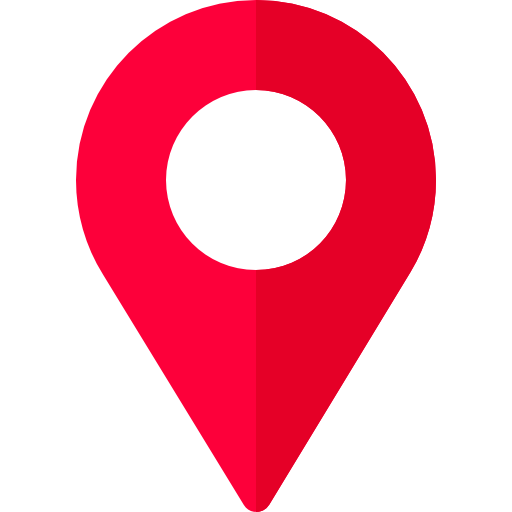
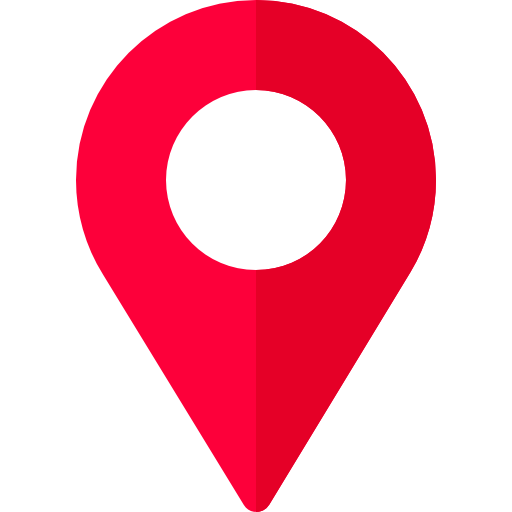
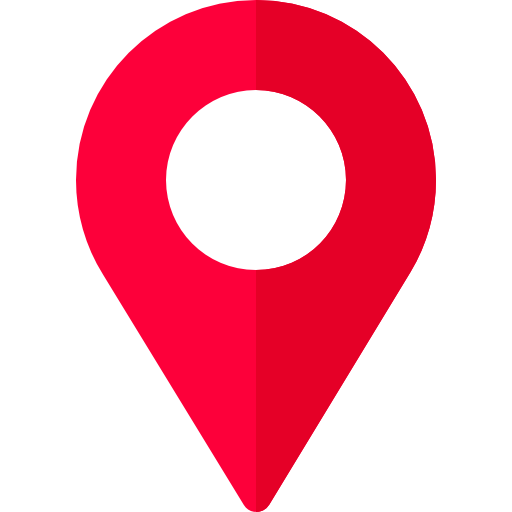
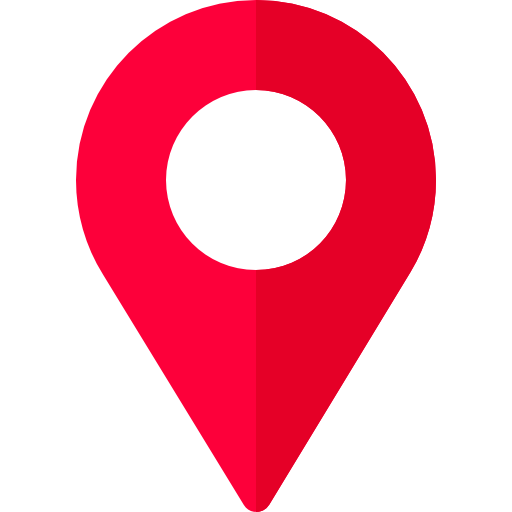
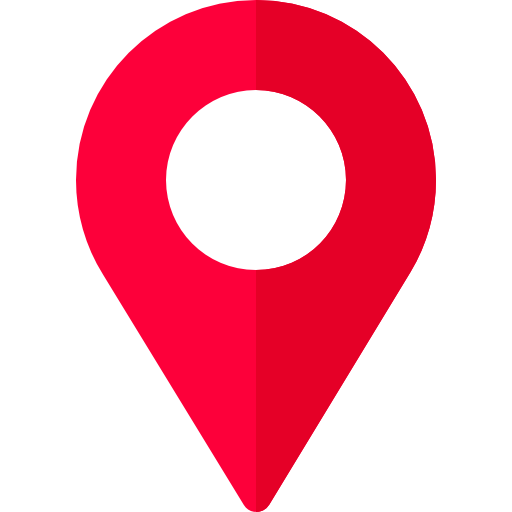
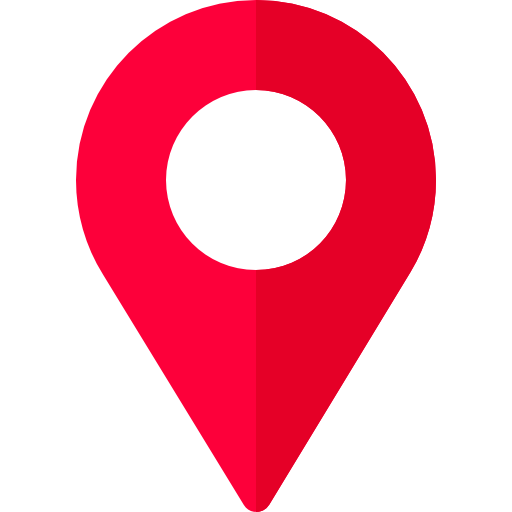
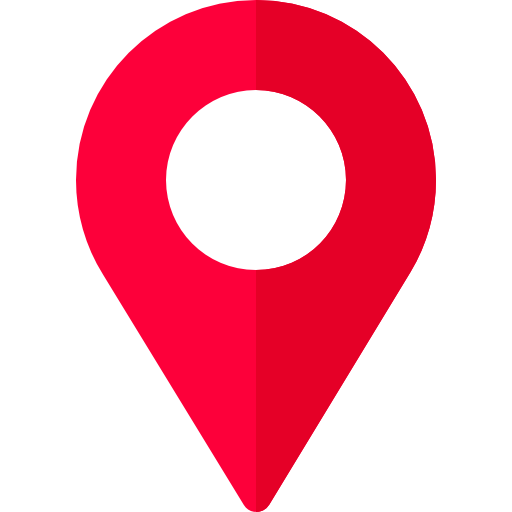
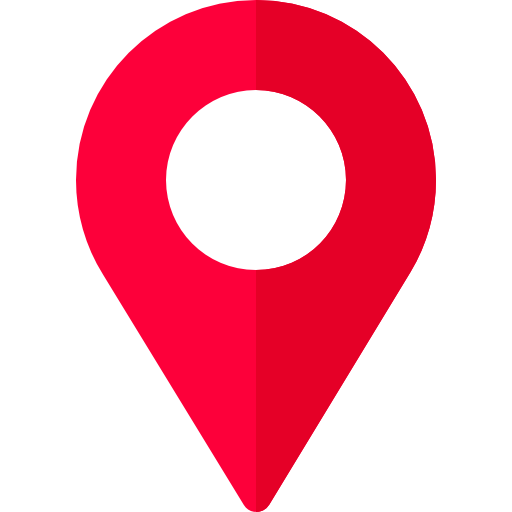
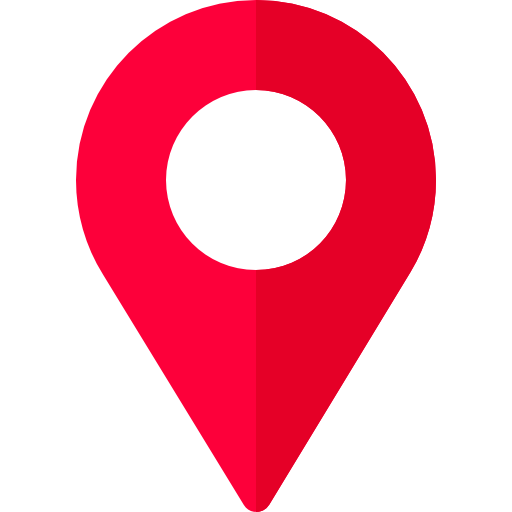
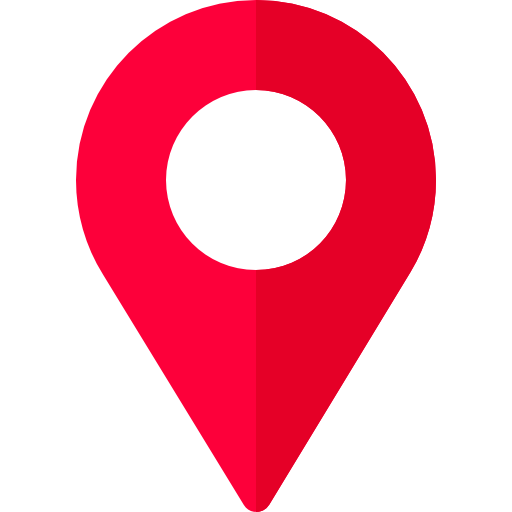
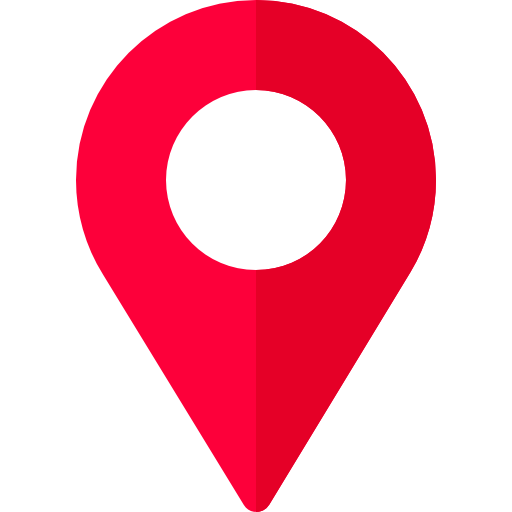
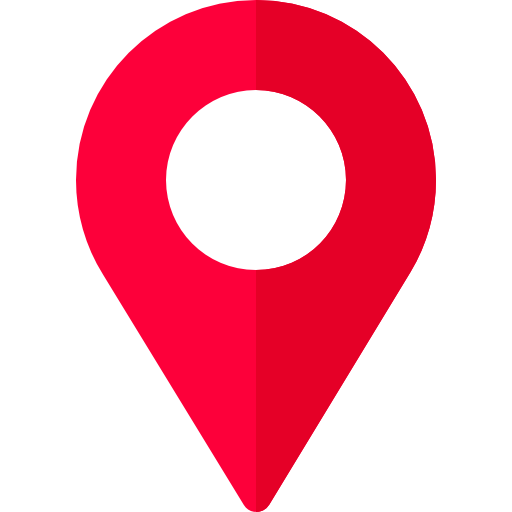
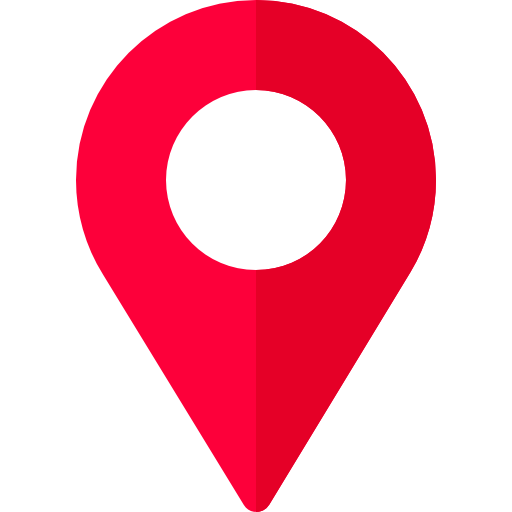
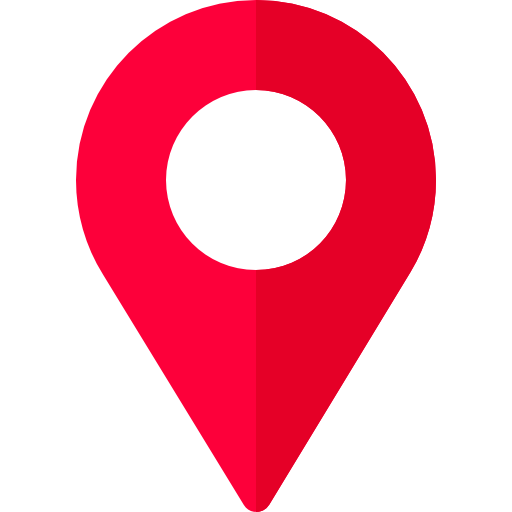
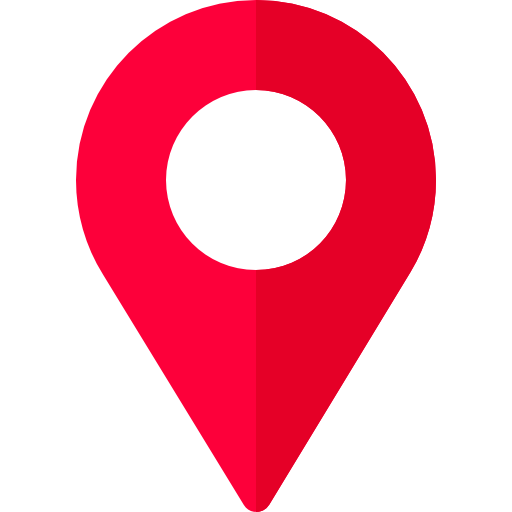
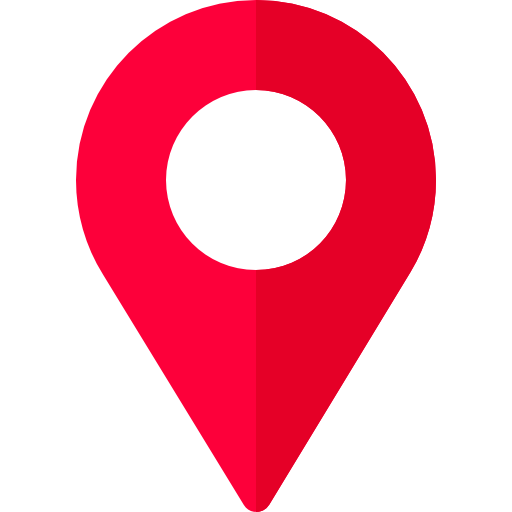
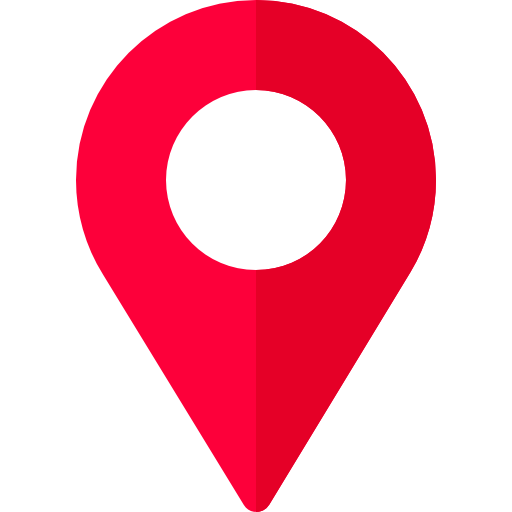
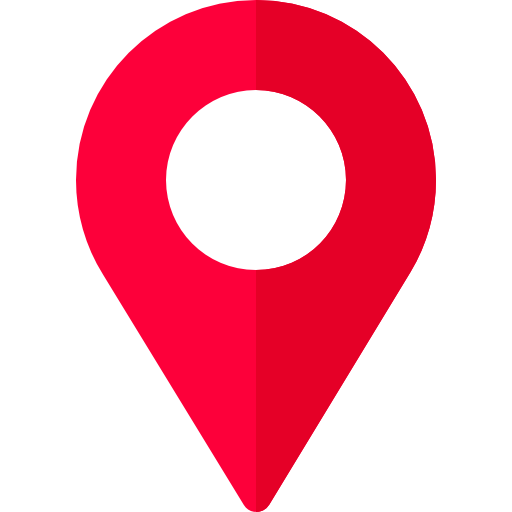
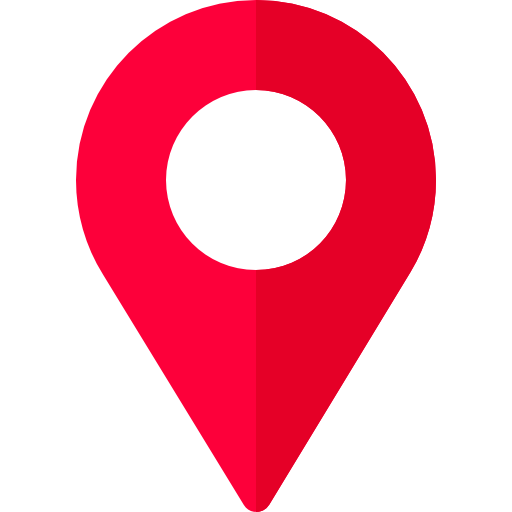
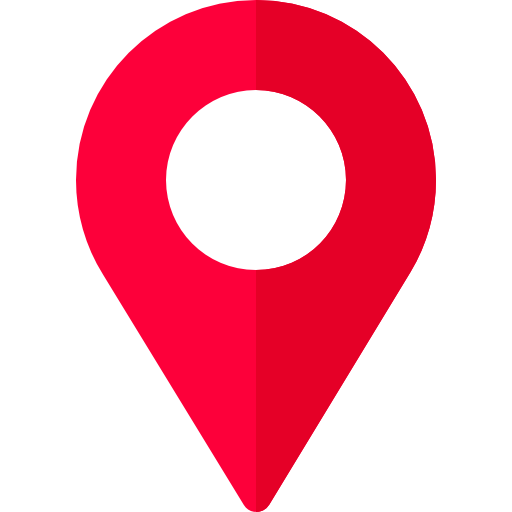
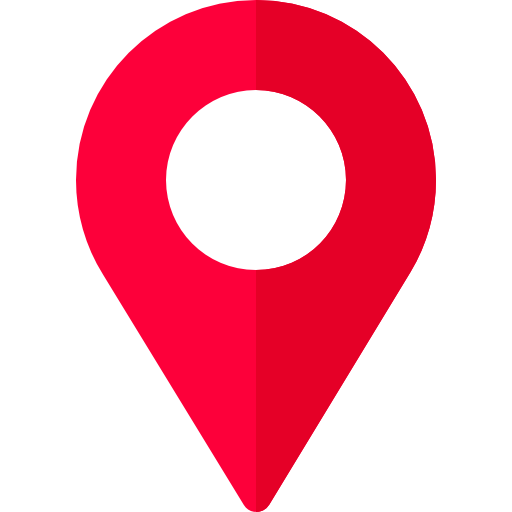
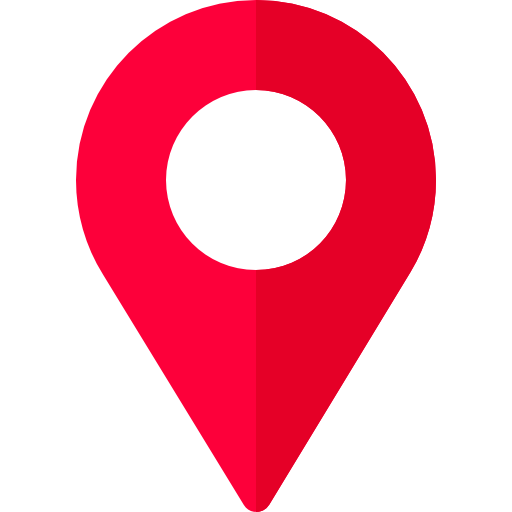
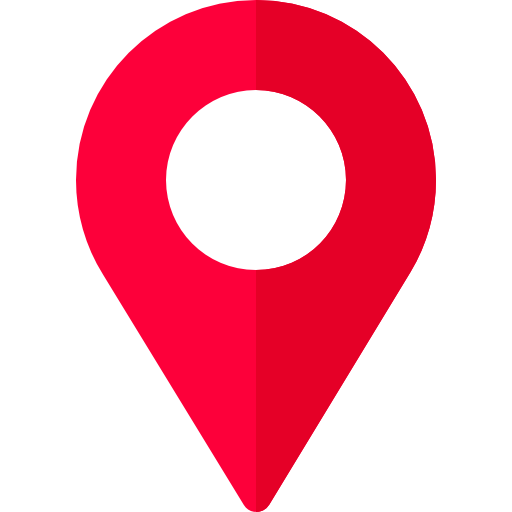
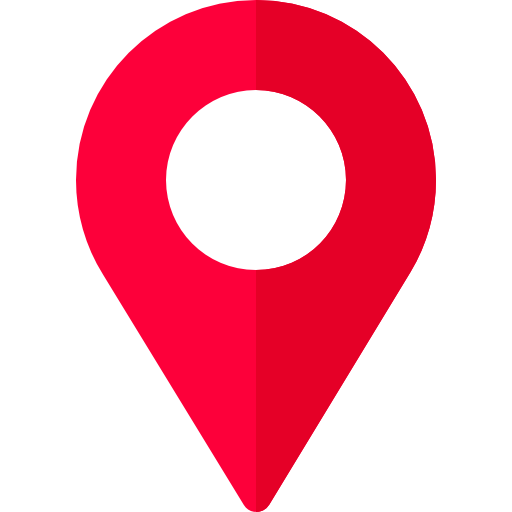
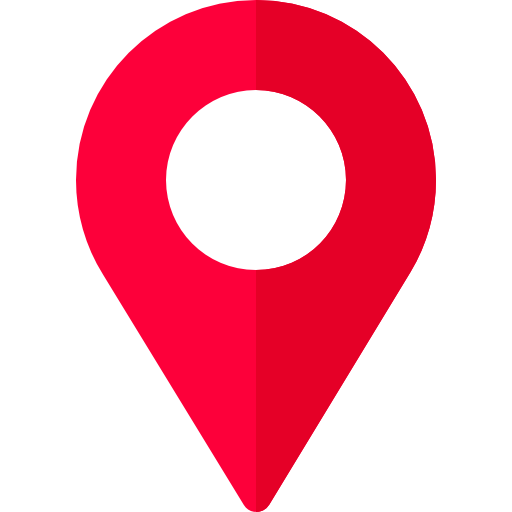
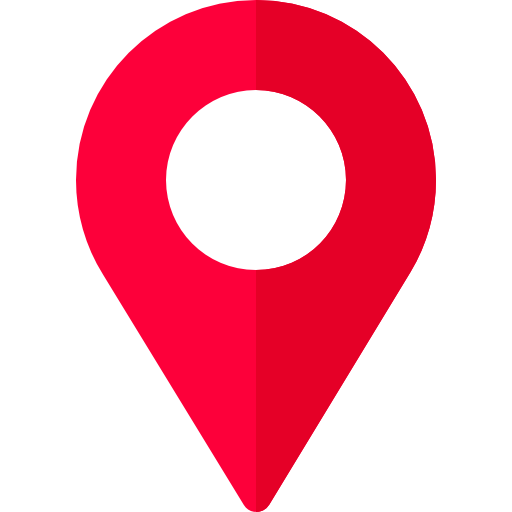
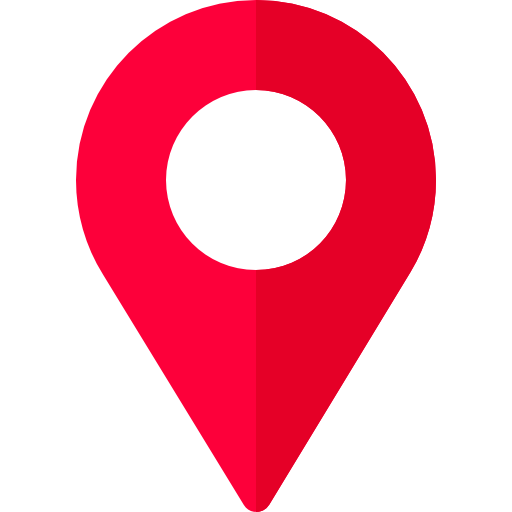
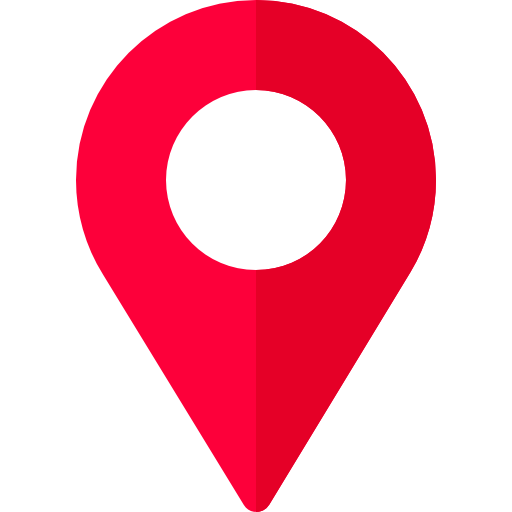
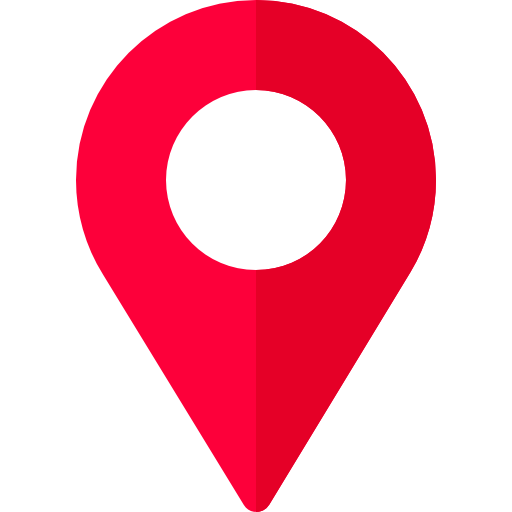
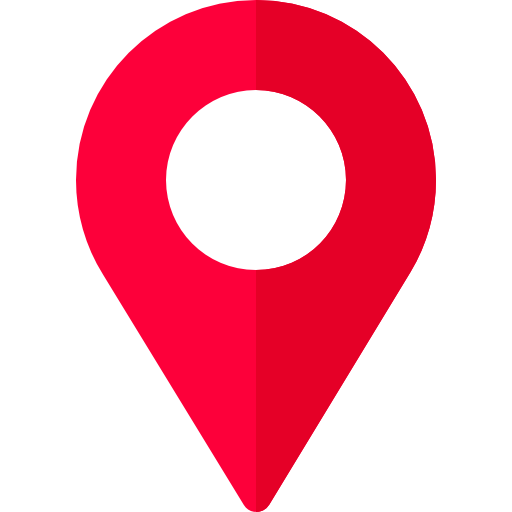
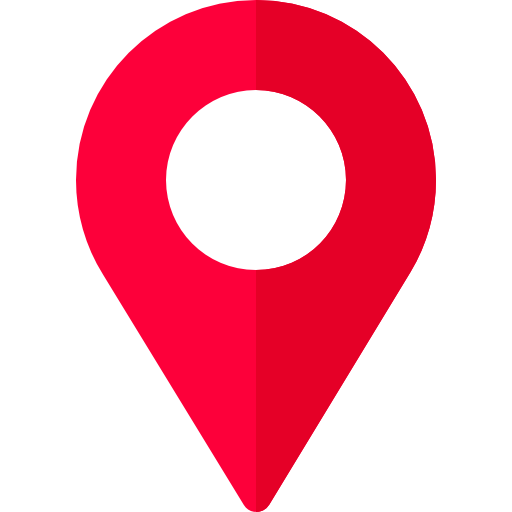
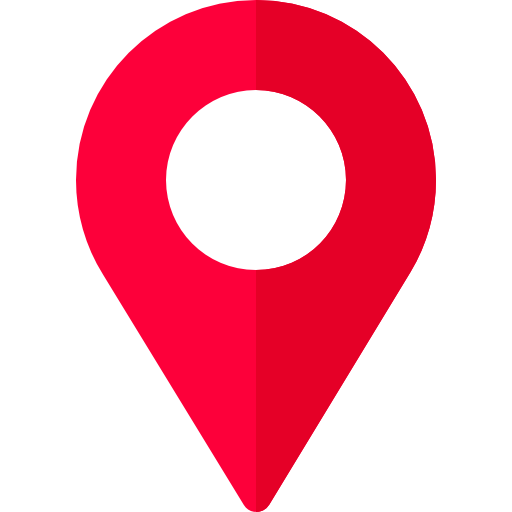
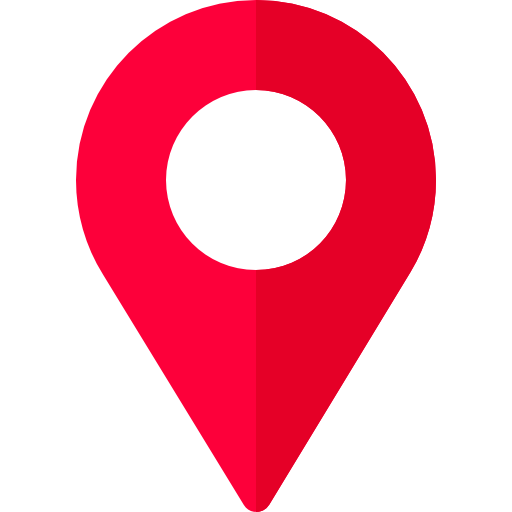
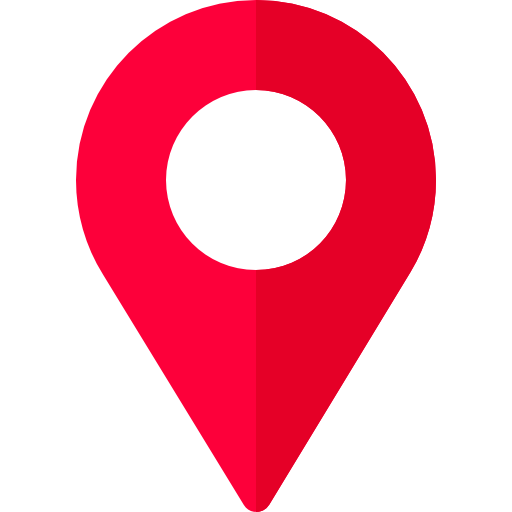
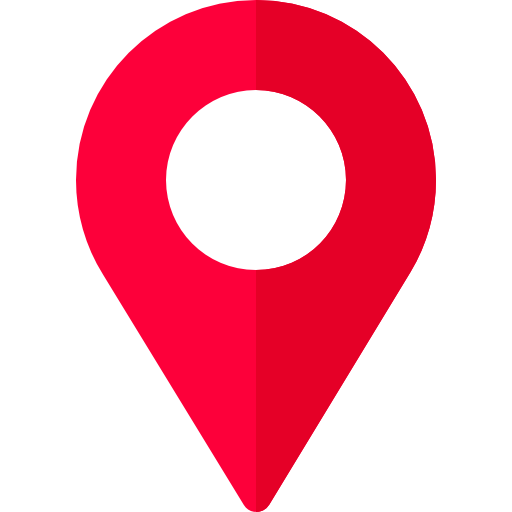
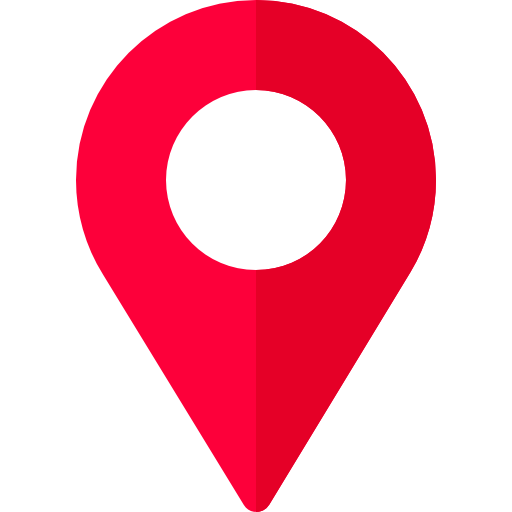
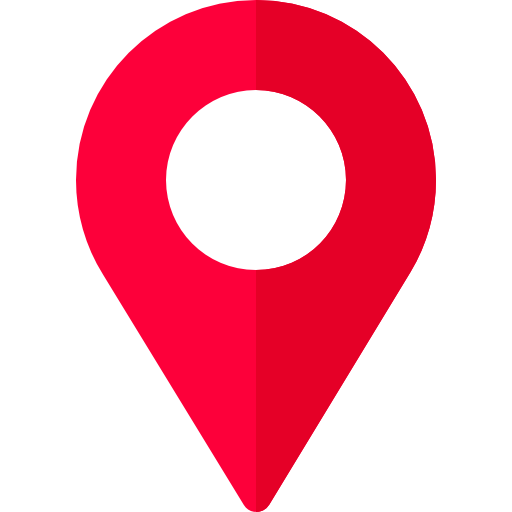
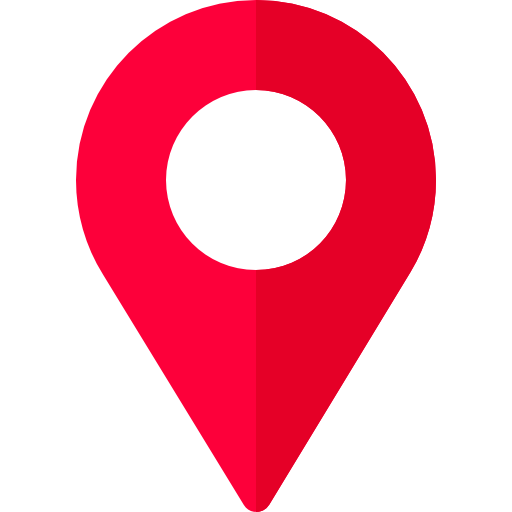
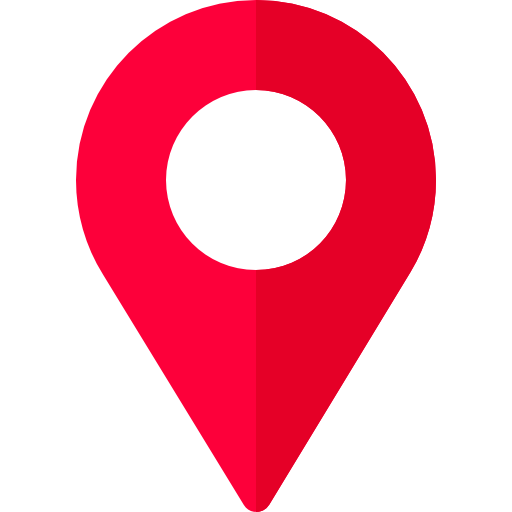
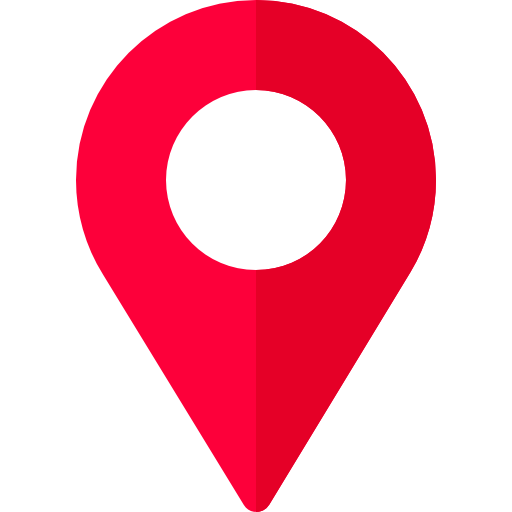
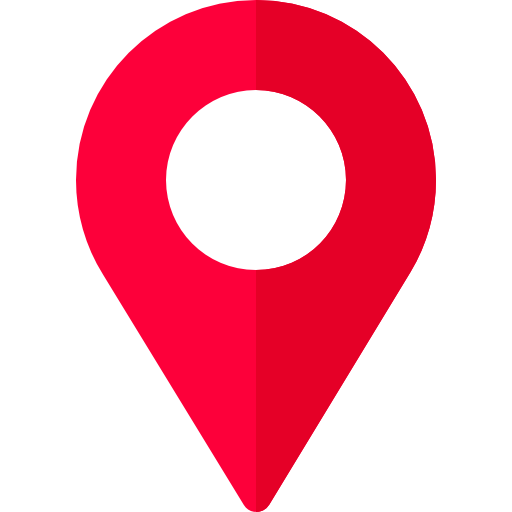
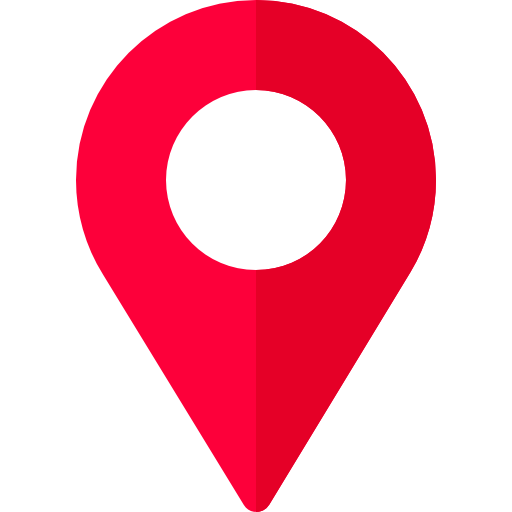
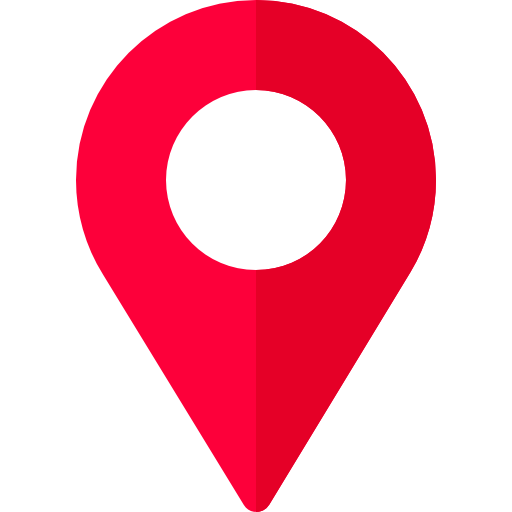
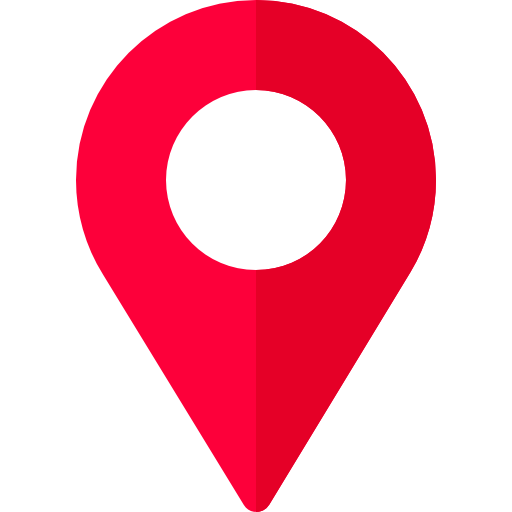
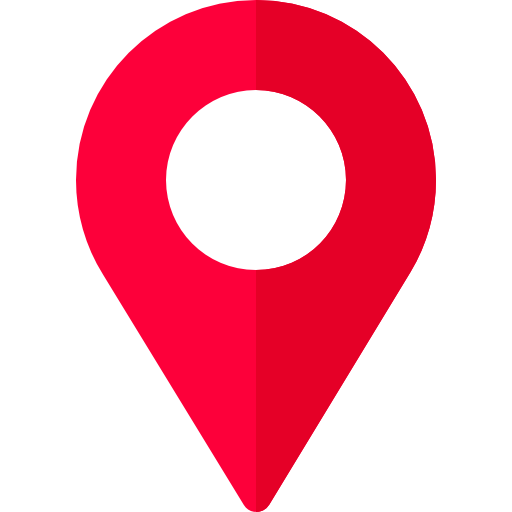
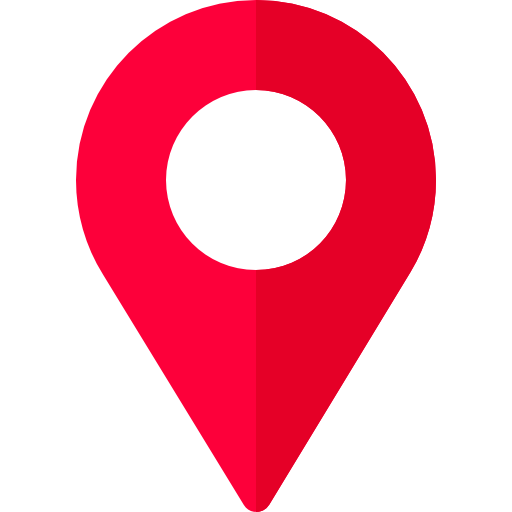
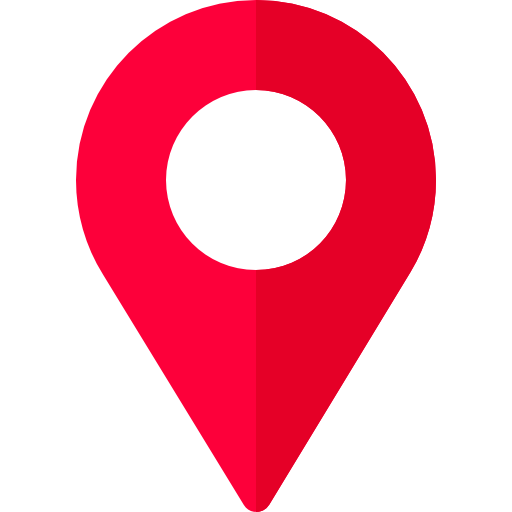
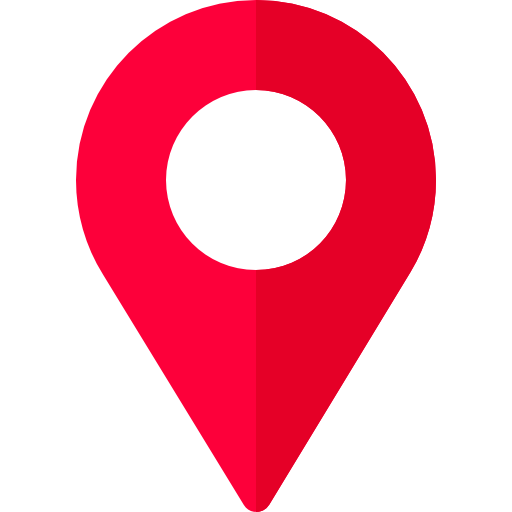
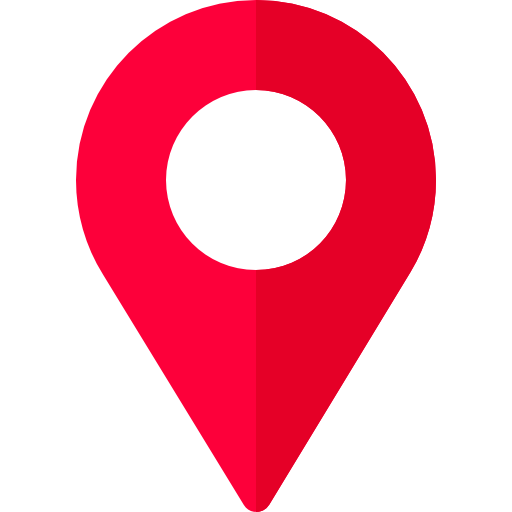
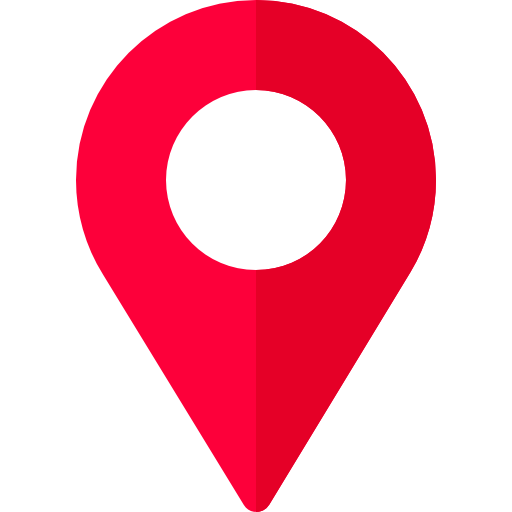
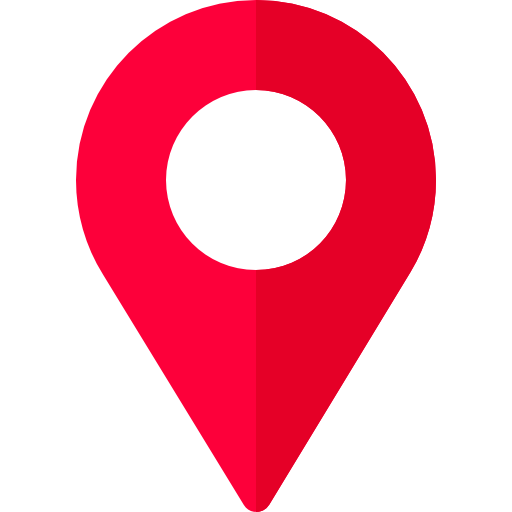
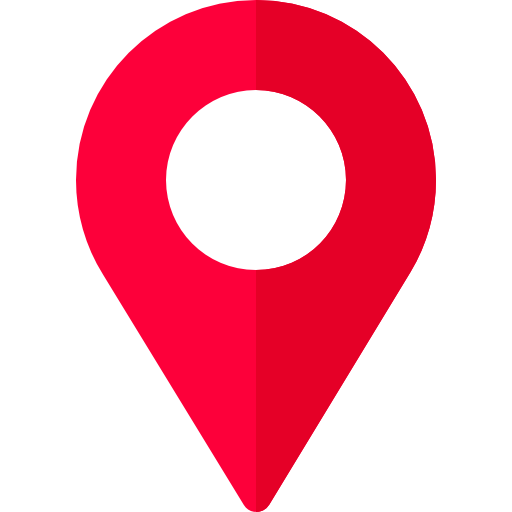
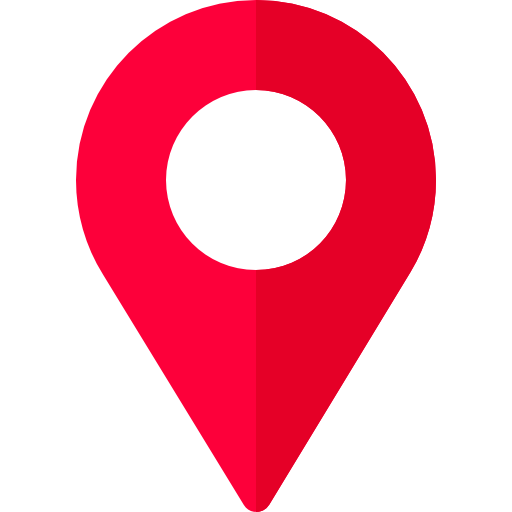
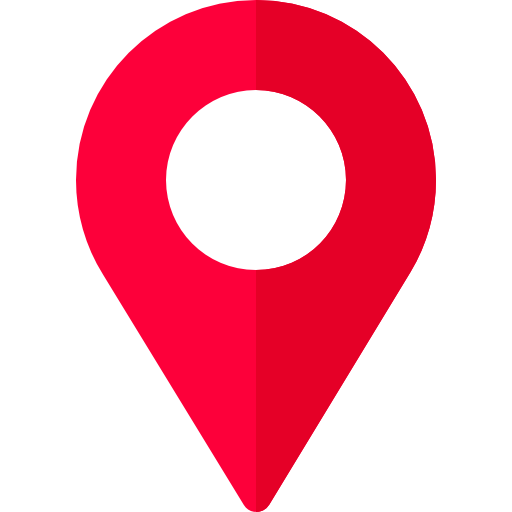
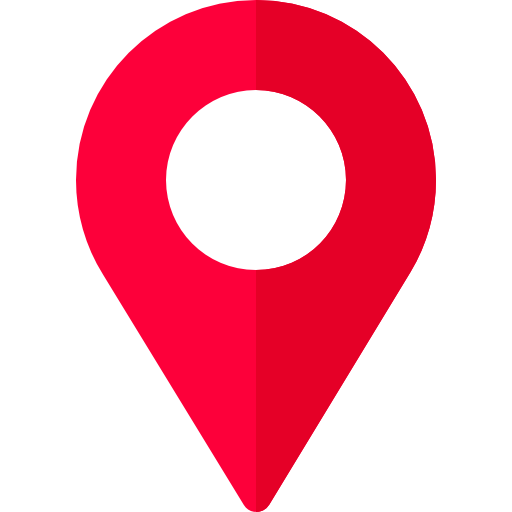
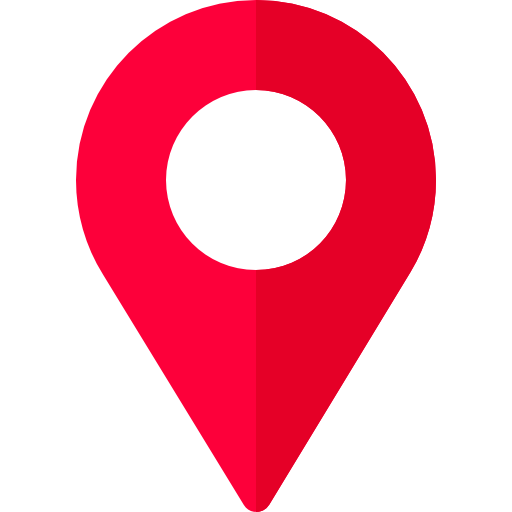
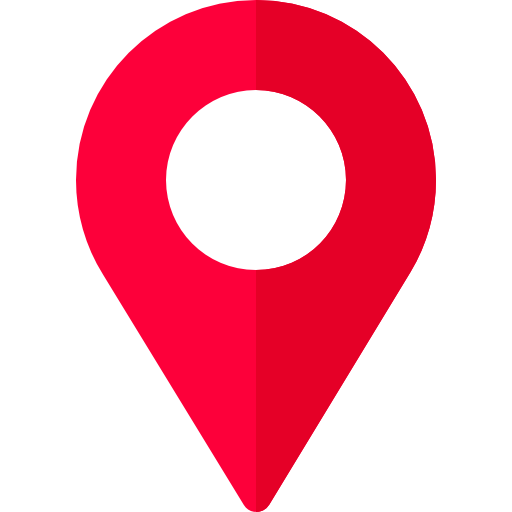
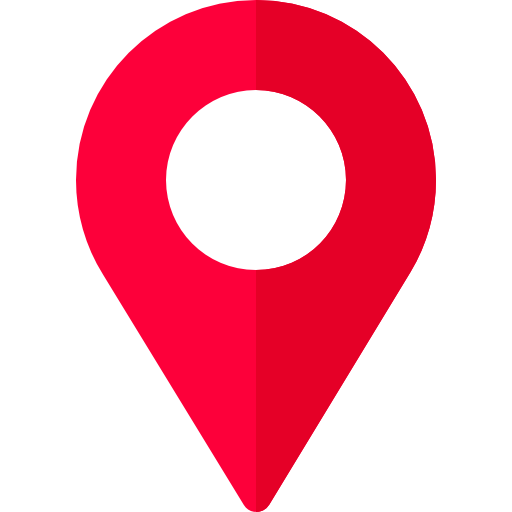
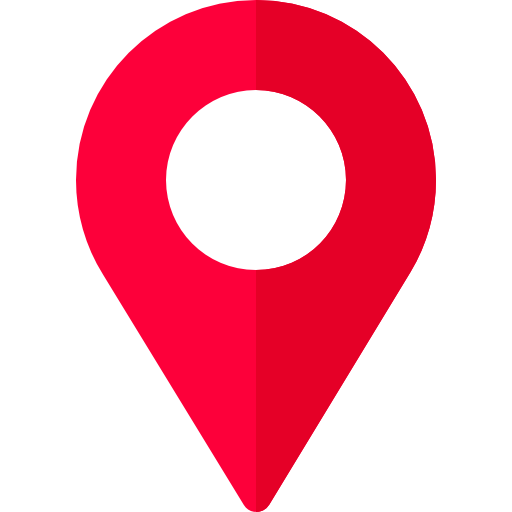
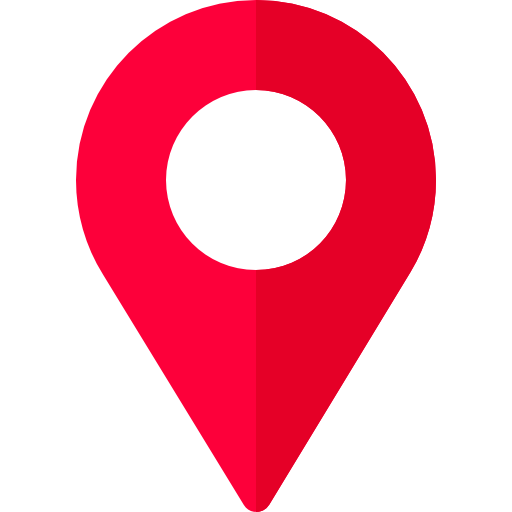
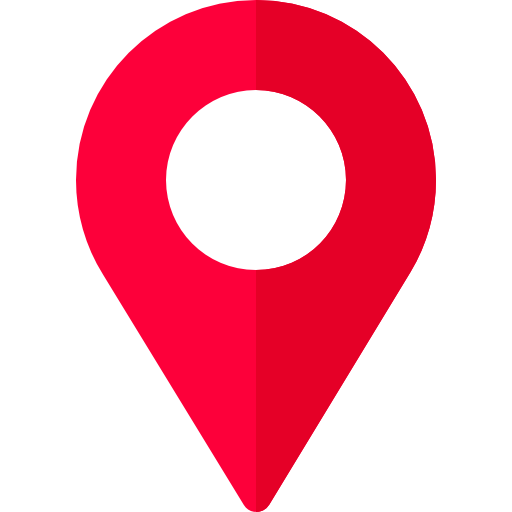
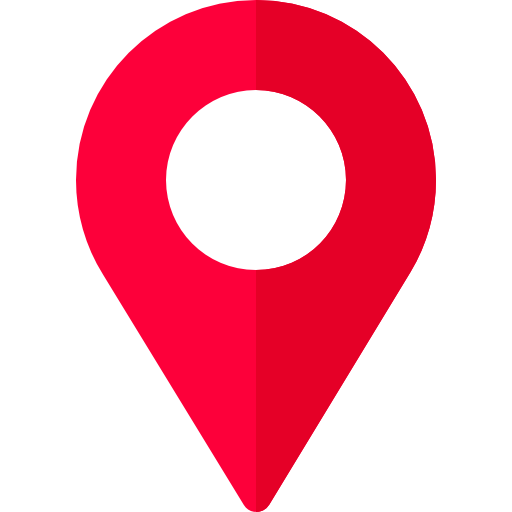
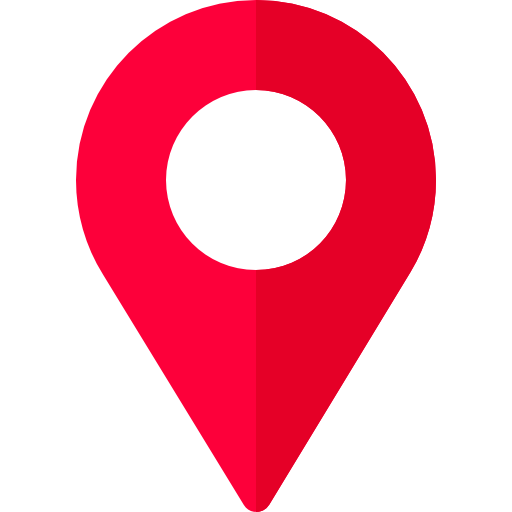
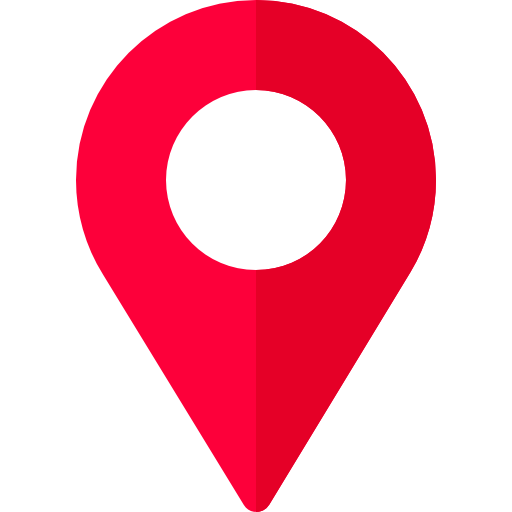
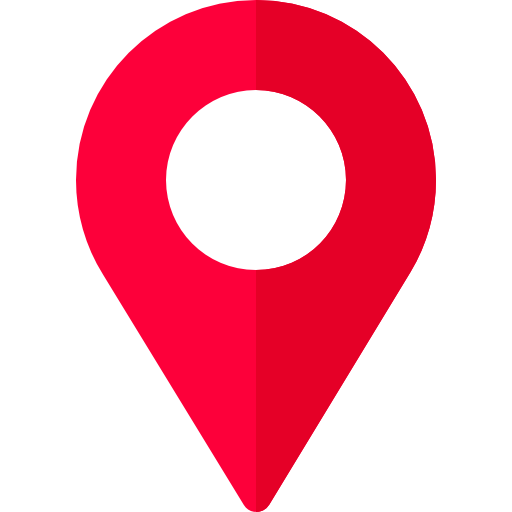
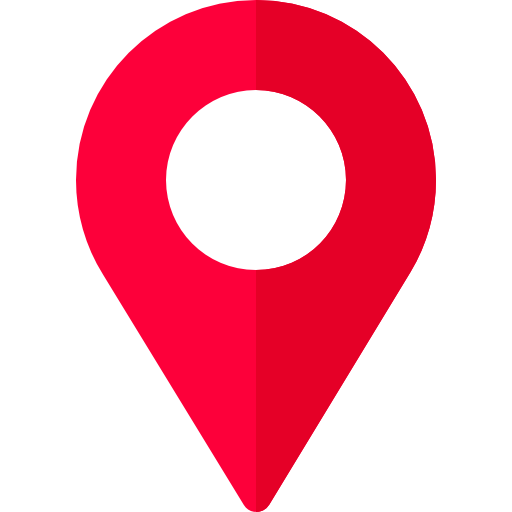
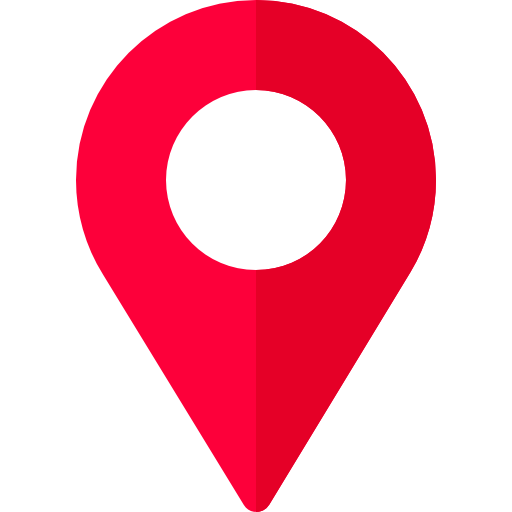
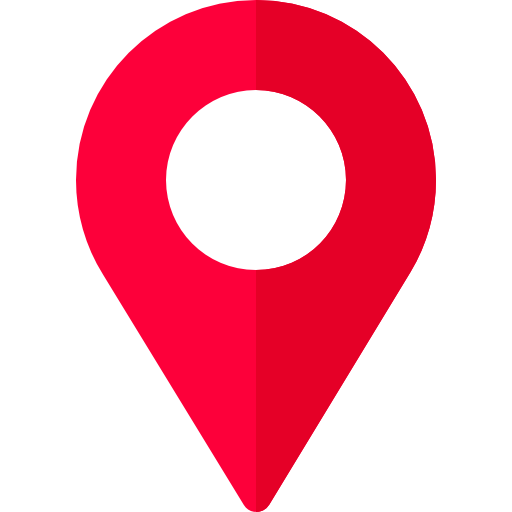
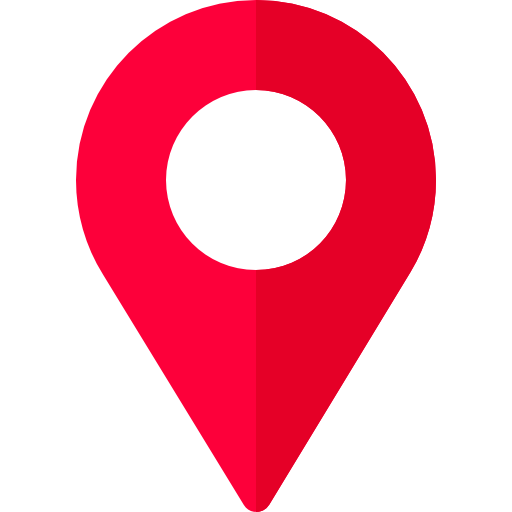
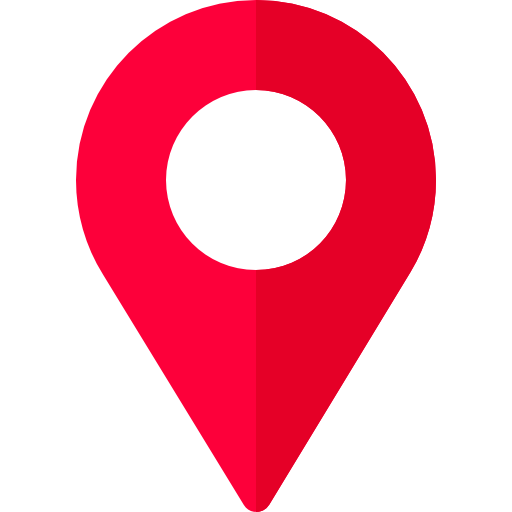
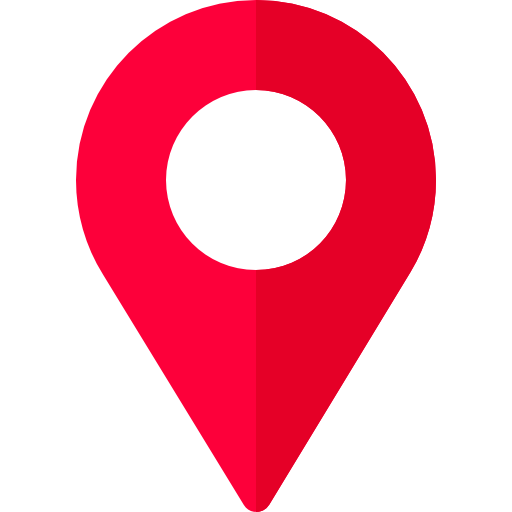
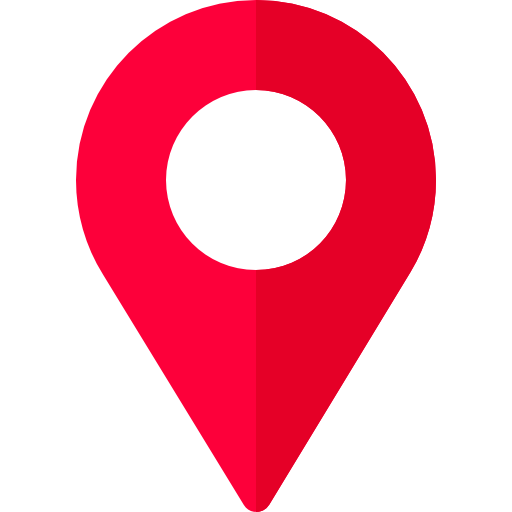
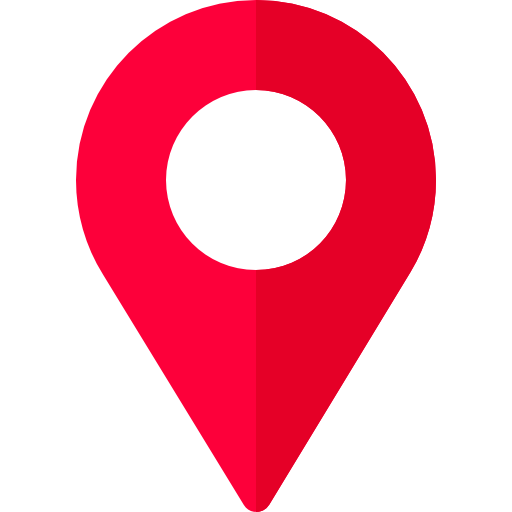
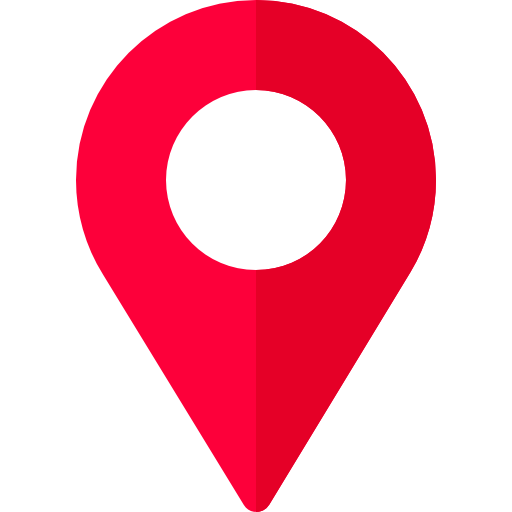
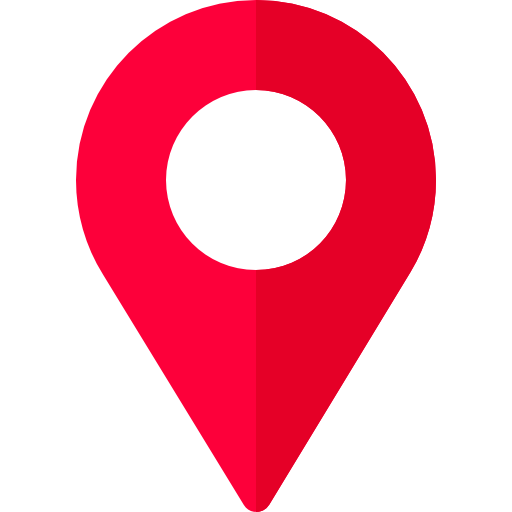
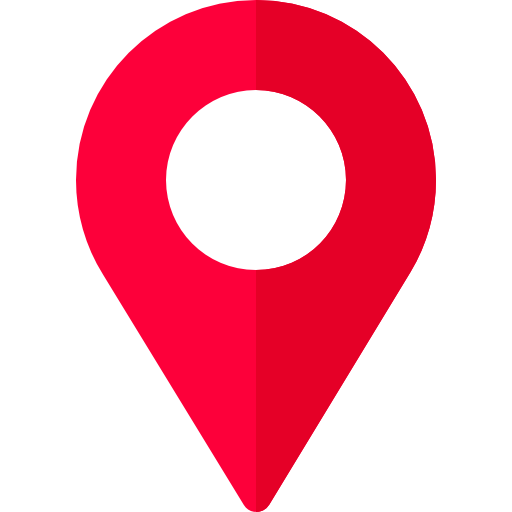
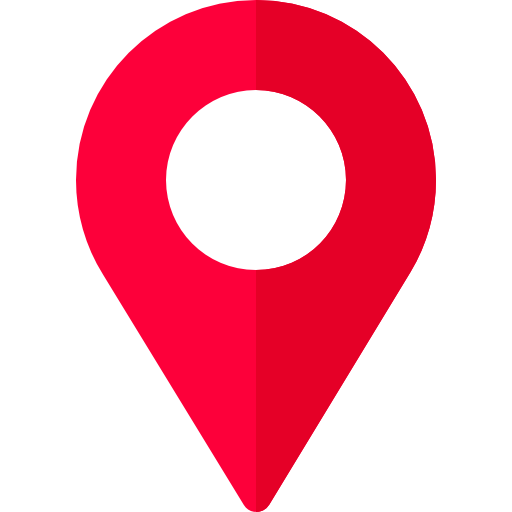
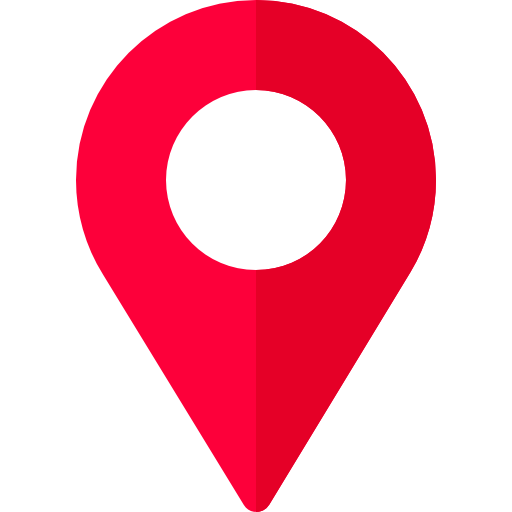
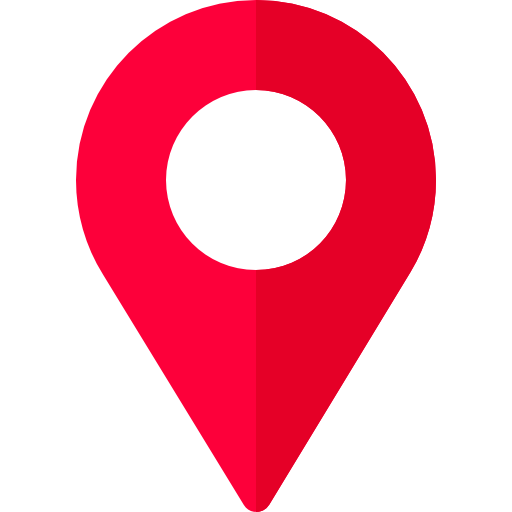
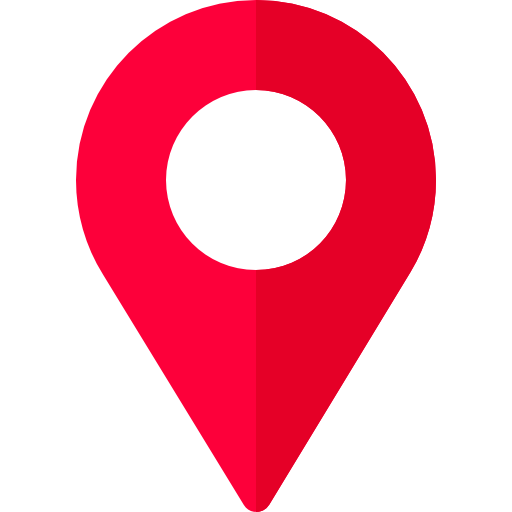
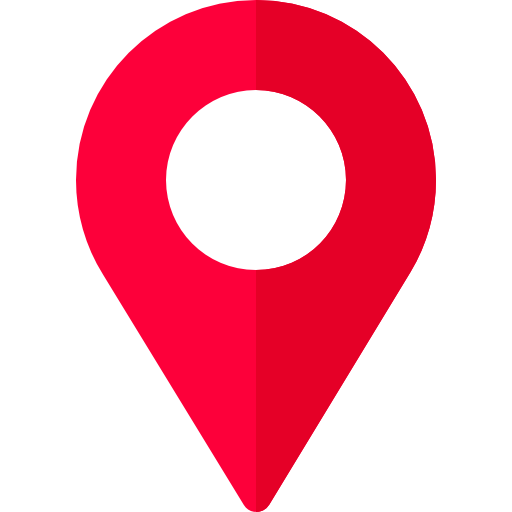
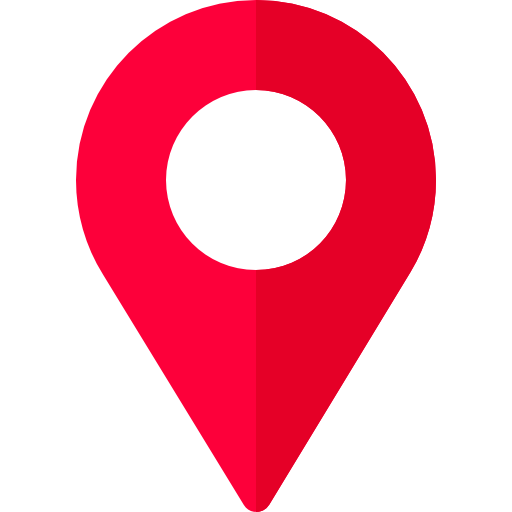
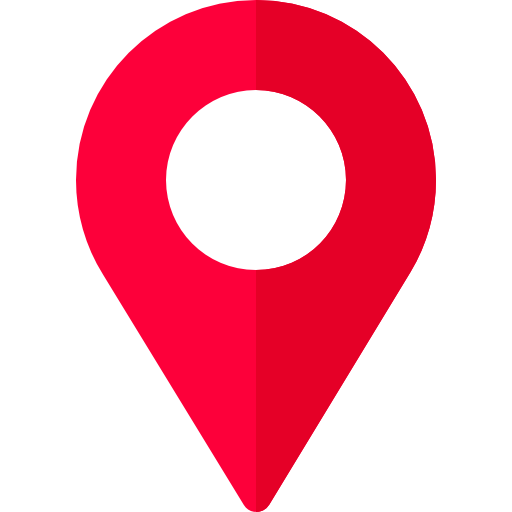
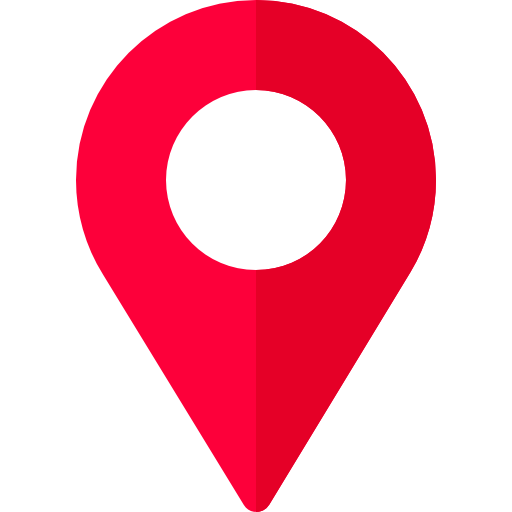
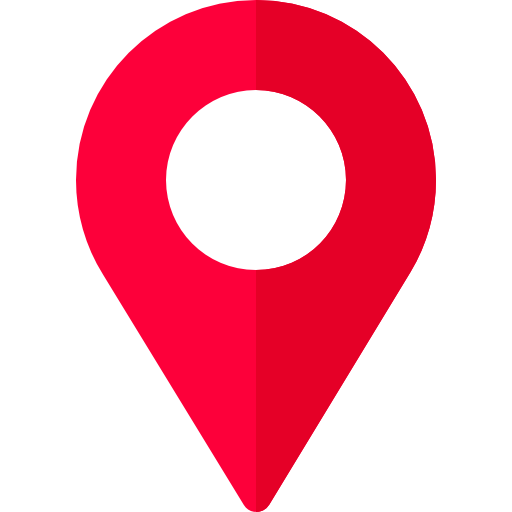
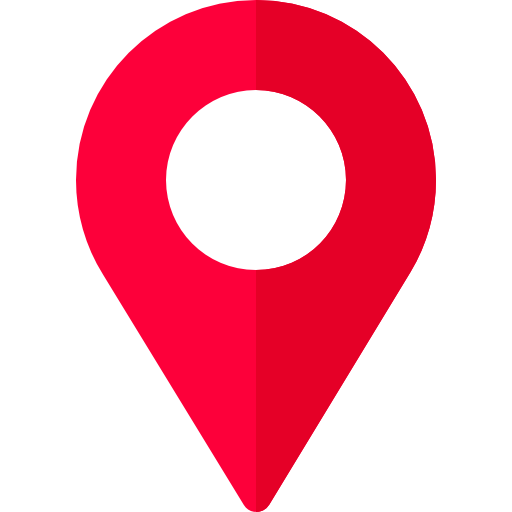
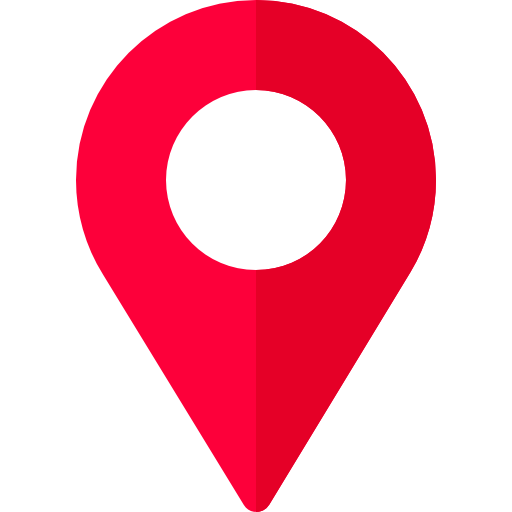
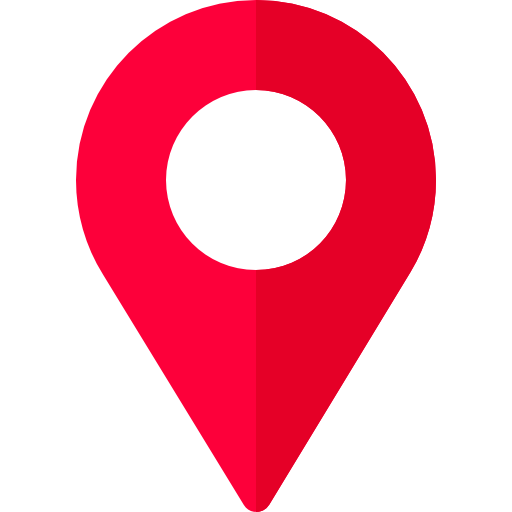
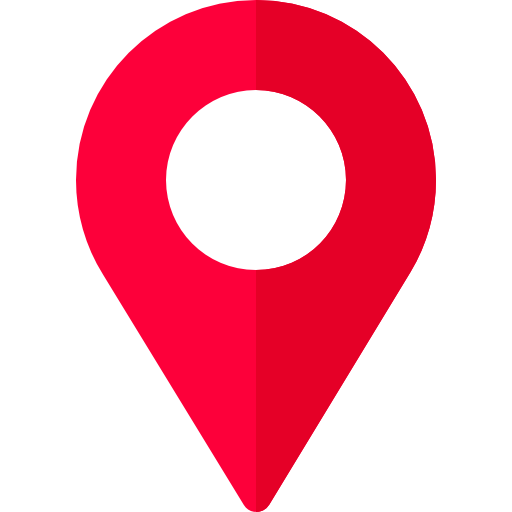
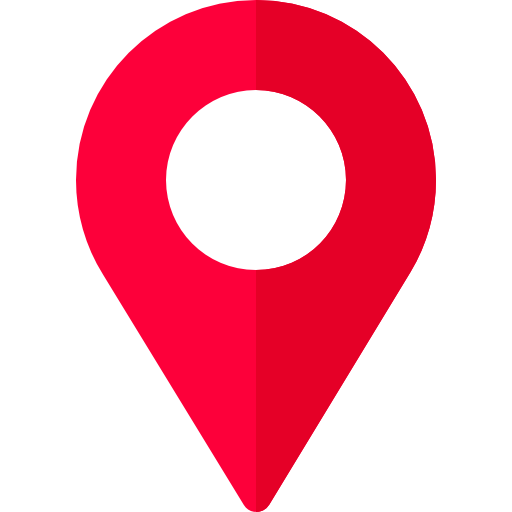
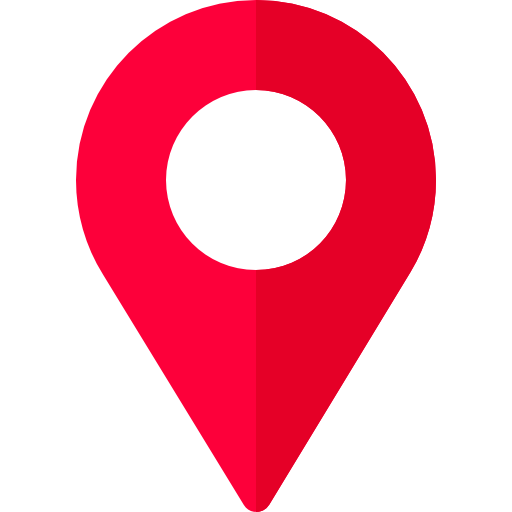
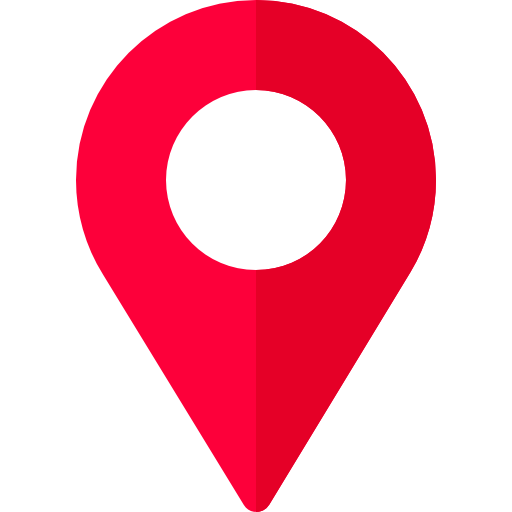

In [5]:
# Folium 지도 객체 생성
m = folium.Map(location=[37.53, 126.84], zoom_start=16)  # 초기 지도 중심 및 확대 수준 설정

# 데이터를 지도에 추가
for geom in df['geometry']:
    coords = [float(coord) for coord in geom.strip('POINT ()').split()]
    # marker = Marker(location=[coords[1], coords[0]])  # 위도와 경도를 역으로 넣음
    # marker.add_to(m)
    
    # 아이콘 설정
    custom_icon = folium.CustomIcon(icon_image='placeholder.png', icon_size=(15, 15))  # 아이콘 크기를 30x30으로 조절
    
    # 마커 생성 및 아이콘 적용
    marker = folium.Marker(location=[coords[1], coords[0]], icon=custom_icon)  # 위도와 경도를 역으로 넣음
    marker.add_to(m)


# 지도를 출력
m

### POINT data type에서 위도 및 경도 추출

In [6]:
df = df[['geometry', '집객시설_총_개수', '상주인구']].sort_values(by = ['집객시설_총_개수', '상주인구'], ascending=[False, True])
df['Longitude'] = df['geometry'].str.extract(r'POINT \((\d+\.\d+) (\d+\.\d+)\)')[0].astype(float)
df['Latitude'] = df['geometry'].str.extract(r'POINT \((\d+\.\d+) (\d+\.\d+)\)')[1].astype(float)
df.head(3)

,geometry,집객시설_총_개수,상주인구,Longitude,Latitude
43,POINT (126.840188 37.54159),145,99,126.840188,37.541590
34,POINT (126.839608 37.541414),144,97,126.839608,37.541414
97,POINT (126.847061 37.531181),136,68,126.847061,37.531181


### [1차 시도] 점(후보입지) 하나를 기준으로 300m 이내 점을 제거
- 집객시설수, 상주인구 수를 기준으로 제거

In [7]:
result_points = []  # 최종 결과로 남길 점들을 담을 리스트

while not df.empty:
    # 인덱스 0번 점을 리스트에 추가
    result_points.append(df.iloc[0]['geometry'])
    
    # 인덱스 0번 점으로부터 200미터 이내의 점을 제거
    reference_point = df.iloc[0]['geometry']
    df = df[df.apply(lambda row: geodesic((df.iloc[0]['Latitude'], df.iloc[0]['Longitude']), (row['Latitude'], row['Longitude'])).meters > 300, axis=1)]

    # 데이터프레임이 비어있지 않은 경우, 인덱스를 다음으로 업데이트
    if not df.empty:
        df = df.reset_index(drop=True)

# 최종 결과 데이터프레임 생성
result_df = pd.DataFrame({'geometry': result_points})

In [8]:
result_df.shape

(12, 1)

### 점 제거 후, 지도 시각화

In [9]:
m = folium.Map(location=[37.53, 126.84], zoom_start=15)  # 초기 지도 중심 및 확대 수준 설정

# 데이터를 지도에 추가
for geom in result_df['geometry']:
    coords = [float(coord) for coord in geom.strip('POINT ()').split()]
    marker = Marker(location=[coords[1], coords[0]])  # 위도와 경도를 역으로 넣음
    marker.add_to(m)


# 지도를 출력
m

### [2차 시도] 집객시설을 기준으로 점 제거

In [11]:
df = pd.read_csv('./final_API.csv')

df = df[['geometry', '집객시설_총_개수']].sort_values(by = '집객시설_총_개수', ascending=False)
df['Longitude'] = df['geometry'].str.extract(r'POINT \((\d+\.\d+) (\d+\.\d+)\)')[0].astype(float)
df['Latitude'] = df['geometry'].str.extract(r'POINT \((\d+\.\d+) (\d+\.\d+)\)')[1].astype(float)

result_points = []  # 최종 결과로 남길 점들을 담을 리스트

while not df.empty:
    # 인덱스 0번 점을 리스트에 추가
    result_points.append(df.iloc[0]['geometry'])
    
    # 인덱스 0번 점으로부터 200미터 이내의 점을 제거
    reference_point = df.iloc[0]['geometry']
    df = df[df.apply(lambda row: geodesic((df.iloc[0]['Latitude'], df.iloc[0]['Longitude']), (row['Latitude'], row['Longitude'])).meters > 550, axis=1)]

    # 데이터프레임이 비어있지 않은 경우, 인덱스를 다음으로 업데이트
    if not df.empty:
        df = df.reset_index(drop=True)

# 최종 결과 데이터프레임 생성
result_df = pd.DataFrame({'geometry': result_points})

m = folium.Map(location=[37.53, 126.84], zoom_start=15)  # 초기 지도 중심 및 확대 수준 설정

# 데이터를 지도에 추가
for geom in result_df['geometry']:
    coords = [float(coord) for coord in geom.strip('POINT ()').split()]
    marker = Marker(location=[coords[1], coords[0]])  # 위도와 경도를 역으로 넣음
    marker.add_to(m)


# 지도를 출력
m

### 1차. 가점수 기준


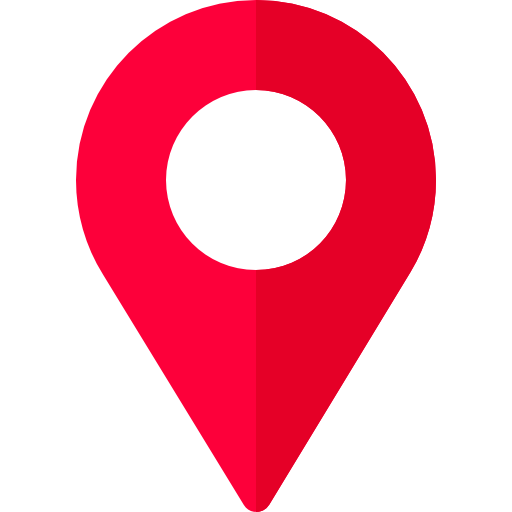
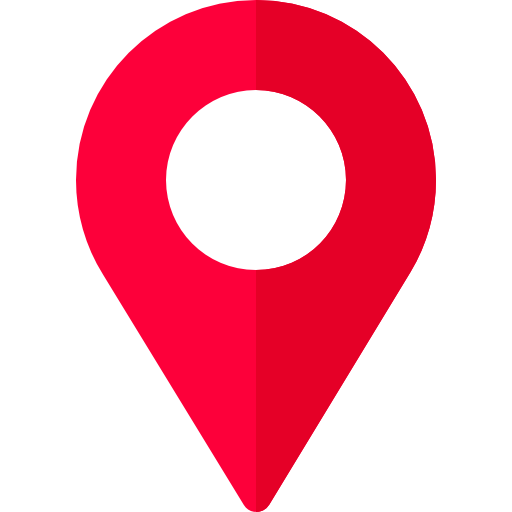
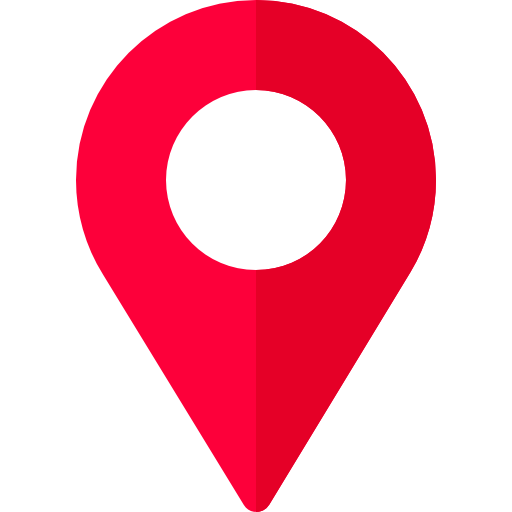
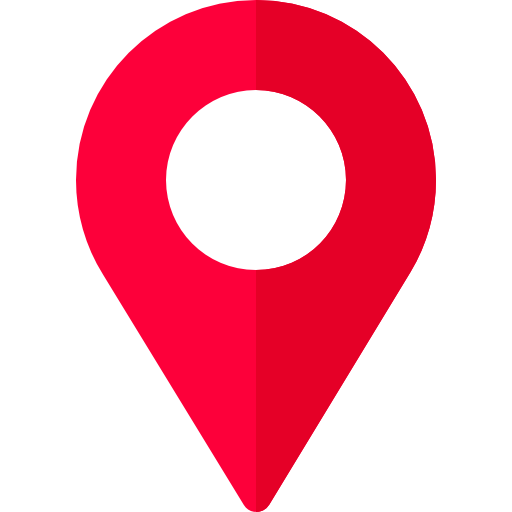
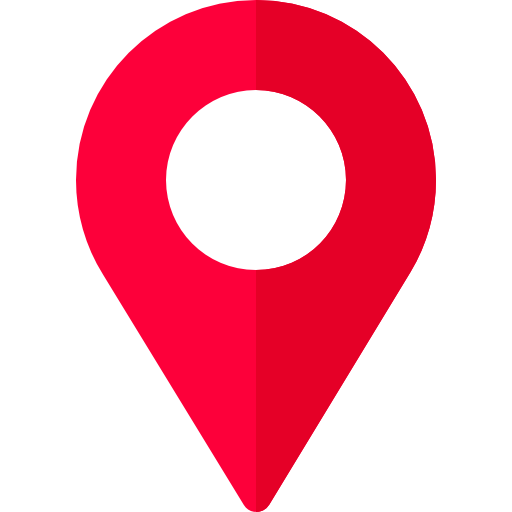

In [16]:
df = pd.read_csv('./final_spots.csv')

df = df[['geometry', '가점수']].sort_values(by = '가점수', ascending=True)
df['Longitude'] = df['geometry'].str.extract(r'POINT \((\d+\.\d+) (\d+\.\d+)\)')[0].astype(float)
df['Latitude'] = df['geometry'].str.extract(r'POINT \((\d+\.\d+) (\d+\.\d+)\)')[1].astype(float)

result_points = []  # 최종 결과로 남길 점들을 담을 리스트

while not df.empty:
    # 인덱스 0번 점을 리스트에 추가
    result_points.append(df.iloc[0]['geometry'])
    
    # 인덱스 0번 점으로부터 00미터 이내의 점을 제거
    reference_point = df.iloc[0]['geometry']
    df = df[df.apply(lambda row: geodesic((df.iloc[0]['Latitude'], df.iloc[0]['Longitude']), (row['Latitude'], row['Longitude'])).meters > 600, axis=1)]

    # 데이터프레임이 비어있지 않은 경우, 인덱스를 다음으로 업데이트
    if not df.empty:
        df = df.reset_index(drop=True)

# 최종 결과 데이터프레임 생성
result_df = pd.DataFrame({'geometry': result_points})
result_df['Order'] = range(1, len(result_df) + 1)

m = folium.Map(location =[37.53, 126.84], zoom_start=15)  # 초기 지도 중심 및 확대 수준 설정

# 데이터를 지도에 추가
for geom in result_df['geometry']:
    coords = [float(coord) for coord in geom.strip('POINT ()').split()]
    # marker = Marker(location=[coords[1], coords[0]])  # 위도와 경도를 역으로 넣음
    # marker.add_to(m)
    
    # 아이콘 설정
    custom_icon = folium.CustomIcon(icon_image='placeholder.png', icon_size=(20, 20))  # 아이콘 크기를 30x30으로 조절
    
    # 마커 생성 및 아이콘 적용
    marker = folium.Marker(location=[coords[1], coords[0]], icon=custom_icon)  # 위도와 경도를 역으로 넣음
    marker.add_to(m)
    
    # 원 추가
    circle = folium.Circle(location=[coords[1], coords[0]], radius=300, color='blue', fill=True, fill_color='blue', fill_opacity=0.15, weight=1)
    circle.add_to(m)


# 지도를 출력
m

In [17]:
df3 = result_df.merge(df2, left_on = 'geometry', right_on = '입지후보지', how = 'left')
df = df3
df.head()

,geometry,Order,도로명,입지후보지,집객시설_총_개수,상주인구_수,가점수
0,POINT (126.845671 37.533482),1,강서로17길,POINT (126.845671 37.533482),58,14354,23
1,POINT (126.838498 37.533759),2,가로공원로76길,POINT (126.838498 37.533759),47,10437,57
2,POINT (126.839934 37.539683),3,강서로31길,POINT (126.839934 37.539683),53,7551,75
3,POINT (126.841488 37.528445),4,곰달래로18길,POINT (126.841488 37.528445),24,11331,85
4,POINT (126.848879 37.527881),5,강서로,POINT (126.848879 37.527881),7,731,201


In [223]:
def calculate_intersection_area(gdf):
    intersection_area_list = []

    # 이미 제거된 점의 집합
    removed_points = set()

    for idx1, row1 in gdf.iterrows():
        if idx1 not in removed_points:  # 이미 제거된 점은 무시
            for idx2, row2 in gdf.iterrows():
                if idx1 != idx2 and idx2 not in removed_points:  # 같은 점과 이미 제거된 점은 무시
                    # 두 점으로부터 원을 생성
                    buffer1 = row1.geometry.buffer(0.0027)  # 300m를 지도 단위로 변환 (대략 0.0027 정도)
                    buffer2 = row2.geometry.buffer(0.0027)

                    # 두 원의 교차 부분을 찾음
                    intersection = buffer1.intersection(buffer2)

                    # 교차 부분의 면적 계산
                    intersection_area = intersection.area

                    # 교차 부분의 면적이 원 면적의 30% 이하인 경우 추가
                    if intersection_area >= 0.3 * buffer1.area:
                        intersection_area_list.append((idx1, idx2))
                        # 두 번째 점을 제거 대상으로 추가
                        removed_points.add(idx2)

    return intersection_area_list

# 교차하는 원의 리스트
intersection_list = calculate_intersection_area(gdf)

# 제거 대상이 된 점들을 모두 제거
filtered_gdf = gdf.drop(index=[j for i, j in intersection_list])

# 초기 지도 설정 (데이터가 있는 중심 지점으로 설정)
center_latitude = (filtered_gdf['위도'].min() + filtered_gdf['위도'].max()) / 2
center_longitude = (filtered_gdf['경도'].min() + filtered_gdf['경도'].max()) / 2
m = folium.Map(location=[center_latitude, center_longitude], zoom_start=13)

# 데이터 포인트를 지도에 추가
for idx, row in filtered_gdf.iterrows():
    folium.Marker([row['위도'], row['경도']], tooltip=row['도로명']).add_to(m)

# 데이터 포인트 주변에 반경 300m 원 그리기
for idx, row in filtered_gdf.iterrows():
    folium.Circle(location=[row['위도'], row['경도']], radius=300, color='blue', fill=True, fill_color='blue', fill_opacity=0.2).add_to(m)

# 지도를 표시
m

In [215]:
def calculate_intersection_area(gdf):
    intersection_area_list = []

    # 이미 제거된 점의 집합
    removed_points = set()

    for idx1, row1 in gdf.iterrows():
        if idx1 not in removed_points:  # 이미 제거된 점은 무시
            for idx2, row2 in gdf.iterrows():
                if idx1 != idx2 and idx2 not in removed_points:  # 같은 점과 이미 제거된 점은 무시
                    # 두 점으로부터 원을 생성
                    buffer1 = row1.geometry.buffer(0.0027)  # 300m를 지도 단위로 변환 (대략 0.0027 정도)
                    buffer2 = row2.geometry.buffer(0.0027)

                    # 두 원의 교차 부분을 찾음
                    intersection = buffer1.intersection(buffer2)

                    # 교차 부분의 면적 계산
                    intersection_area = intersection.area

                    # 교차 부분의 면적이 원 면적의 10%를 넘으면 추가
                    if intersection_area >= 0.5 * buffer1.area:
                        intersection_area_list.append((idx1, idx2))
                        # 두 번째 점을 제거 대상으로 추가
                        removed_points.add(idx2)

    return intersection_area_list

# 교차하는 원의 리스트
intersection_list = calculate_intersection_area(gdf)


# 제거 대상이 된 점들을 모두 제거
filtered_gdf = gdf.drop(index=[j for i, j in intersection_list])

# 결과 출력
filtered_gdf


,geometry,Order,도로명,입지후보지,집객시설_총_개수,상주인구_수,가점수,경도,위도
0,POINT (126.84567 37.53348),1,강서로17길,POINT (126.845671 37.533482),58,14354,23,126.845671,37.533482
1,POINT (126.84468 37.53084),2,곰달래로19나길,POINT (126.844676 37.530839),50,15012,26,126.844676,37.530839
2,POINT (126.84081 37.52976),3,월정로20길,POINT (126.84081 37.529755),31,13760,56,126.840810,37.529755
3,POINT (126.83850 37.53376),4,가로공원로76길,POINT (126.838498 37.533759),47,10437,57,126.838498,37.533759
4,POINT (126.83993 37.53968),5,강서로31길,POINT (126.839934 37.539683),53,7551,75,126.839934,37.539683
5,POINT (126.84788 37.52974),6,강서로7길,POINT (126.847877 37.529743),56,5117,93,126.847877,37.529743
6,POINT (126.84197 37.53432),7,가로공원로84길,POINT (126.841965 37.534317),18,13244,96,126.841965,37.534317
7,POINT (126.83561 37.54035),8,화곡로18길,POINT (126.835605 37.540346),47,4152,107,126.835605,37.540346
8,POINT (126.83628 37.53703),9,가로공원로,POINT (126.836279 37.537027),23,8472,111,126.836279,37.537027
9,POINT (126.84309 37.53766),10,강서로,POINT (126.843087 37.537657),7,6366,167,126.843087,37.537657
